<a href="https://colab.research.google.com/github/zilingggg/Unet/blob/main/trainUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone 'https://github.com/zhixuhao/unet.git'

fatal: destination path 'unet' already exists and is not an empty directory.


In [ ]:
import os, glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np  # Added import for numpy
import cv2          # Added import for opencv-python

print("TensorFlow version:", tf.__version__)

# 這裡改成你自己的資料路徑
ROOT = "/content/drive/MyDrive/mask rcnn"

train_img_dir  = os.path.join(ROOT, "img_train")
train_mask_dir = os.path.join(ROOT, "mask_train")
test_img_dir   = os.path.join(ROOT, "img_test")
test_mask_dir  = os.path.join(ROOT, "mask_test")

print("Train images:", len(os.listdir(train_img_dir)))
print("Train masks :", len(os.listdir(train_mask_dir)))
print("Test images :", len(os.listdir(test_img_dir)))
print("Test masks  :", len(os.listdir(test_mask_dir)))


TensorFlow version: 2.19.0
Train images: 1265
Train masks : 1539
Test images : 285
Test masks  : 324


In [ ]:
def build_image_mask_map(image_dir, mask_dir):
    # 1️⃣ 先整理所有 mask：依 base_name 分組
    mask_groups = {}
    for mask_filename in os.listdir(mask_dir):
        if not mask_filename.endswith(".png"):
            continue
        parts = mask_filename.split('_')
        if len(parts) < 6:
            print("Unexpected mask filename:", mask_filename)
            continue

        # ★ 命名邏輯的第一個關鍵：
        #    這一行決定「哪些檔名被當成同一張影像的一組」
        base_name = '_'.join(parts[:5])  # 例如: Calc-Test_P_01670_LEFT_CC

        mask_groups.setdefault(base_name, []).append(
            os.path.join(mask_dir, mask_filename)
        )

    print("Found", len(mask_groups), "unique base_names in masks")

    img_paths = []
    mask_lists = []

    # 2️⃣ 再去 image_dir 逐一看 image，拿同一個 base_name 的 masks 來配對
    for img_filename in os.listdir(image_dir):
        if not img_filename.endswith(".png"):
            continue

        parts = img_filename.split('_')
        if len(parts) < 6:
            print("Unexpected image filename:", img_filename)
            continue

        # ★ 命名邏輯的第二個關鍵：
        #    這裡用一樣的方式算出 base_name，來對應剛剛的 mask_groups
        base_name = '_'.join(parts[:5])

        img_path = os.path.join(image_dir, img_filename)

        # ★ 命名邏輯的第三個關鍵：
        #    用 base_name 當 key，找到「這張 image 對應的全部 mask」
        masks_for_img = mask_groups.get(base_name, [])

        if len(masks_for_img) == 0:
            print(f"[WARN] No mask found for image {img_filename} (base_name={base_name})")
            continue

        img_paths.append(img_path)
        mask_lists.append(masks_for_img)

    print("Usable images:", len(img_paths))
    return img_paths, mask_lists


In [ ]:
train_img_paths, train_mask_lists = build_image_mask_map(train_img_dir, train_mask_dir)

for i in range(3):
    print("IMAGE:", os.path.basename(train_img_paths[i]))
    print("MASKS:")
    for m in train_mask_lists[i]:
        print("   ", os.path.basename(m))
    print("-" * 30)


Found 1224 unique base_names in masks
Usable images: 1265
IMAGE: Calc-Training_P_01691_RIGHT_MLO_1-1.png
MASKS:
    Calc-Training_P_01691_RIGHT_MLO_1-3.png
    Calc-Training_P_01691_RIGHT_MLO_2-3.png
    Calc-Training_P_01691_RIGHT_MLO_3-3.png
------------------------------
IMAGE: Calc-Training_P_01628_RIGHT_CC_1-1.png
MASKS:
    Calc-Training_P_01628_RIGHT_CC_2-3.png
    Calc-Training_P_01628_RIGHT_CC_1-3.png
------------------------------
IMAGE: Calc-Training_P_01659_LEFT_CC_1-1.png
MASKS:
    Calc-Training_P_01659_LEFT_CC_1-3.png
------------------------------


In [ ]:
test_img_paths, test_mask_lists = build_image_mask_map(test_img_dir, test_mask_dir)

for i in range(3):
    print("IMAGE:", os.path.basename(test_img_paths[i]))
    print("MASKS:")
    for m in test_mask_lists[i]:
        print("   ", os.path.basename(m))
    print("-" * 30)


Found 284 unique base_names in masks
Usable images: 285
IMAGE: Calc-Test_P_01502_LEFT_CC_1-1 (1).png
MASKS:
    Calc-Test_P_01502_LEFT_CC_2-3.png
------------------------------
IMAGE: Calc-Test_P_01352_LEFT_MLO_1-1.png
MASKS:
    Calc-Test_P_01352_LEFT_MLO_1-3.png
------------------------------
IMAGE: Calc-Test_P_01353_LEFT_CC_1-1.png
MASKS:
    Calc-Test_P_01353_LEFT_CC_1-3.png
------------------------------


In [ ]:
import numpy as np
import cv2

print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")

NumPy version: 2.0.2
OpenCV version: 4.12.0


In [ ]:
IMG_SIZE   = 256
BATCH_SIZE = 4

class MultiMaskUNetSequence(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_lists, img_size=256, batch_size=4, shuffle=True):
        self.img_paths  = img_paths          # list[str]
        self.mask_lists = mask_lists         # list[list[str]]
        self.img_size   = img_size
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.indices    = np.arange(len(self.img_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_imgs  = []
        batch_masks = []

        for i in batch_idx:
            img_path  = self.img_paths[i]
            mask_list = self.mask_lists[i]

            # --- 讀影像 ---
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype(np.float32) / 255.0

            # --- 合併多個 mask ---
            merged_mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
            for m_path in mask_list:
                m = cv2.imread(m_path, cv2.IMREAD_GRAYSCALE)
                if m is None:
                    print("[WARN] Failed to load mask:", m_path)
                    continue
                m = cv2.resize(m, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
                m = (m > 0).astype(np.float32)      # >0 即視為 1
                merged_mask = np.maximum(merged_mask, m)

            # [H,W,3], [H,W,1]
            batch_imgs.append(img)
            batch_masks.append(merged_mask[..., np.newaxis])

        batch_imgs  = np.stack(batch_imgs,  axis=0)
        batch_masks = np.stack(batch_masks, axis=0)

        return batch_imgs, batch_masks

train_seq = MultiMaskUNetSequence(train_img_paths, train_mask_lists,
                                  img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_seq   = MultiMaskUNetSequence(test_img_paths,  test_mask_lists,
                                  img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

len(train_seq), len(val_seq)


(317, 72)

Showing image: /content/drive/MyDrive/mask rcnn/img_test/Calc-Test_P_01502_LEFT_CC_1-1 (1).png
img min/max: 0.0 0.7647059
mask min/max: 0.0 1.0
mask unique: [0. 1.]


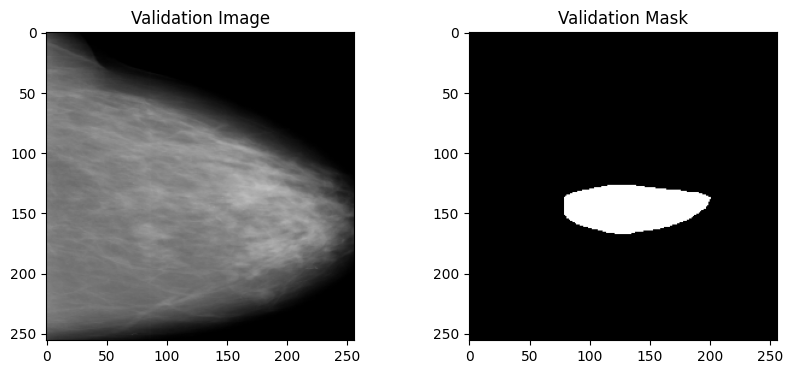

In [ ]:
idx = 0  # 看 validation 的第 0 個 batch
imgs, masks = val_seq[idx]

# 取得該 batch 原始圖片檔名
batch_filenames = val_seq.img_paths[idx * val_seq.batch_size : (idx+1) * val_seq.batch_size]
current_img_file = batch_filenames[0]

print("Showing image:", current_img_file)
print("img min/max:", imgs[0].min(), imgs[0].max())
print("mask min/max:", masks[0].min(), masks[0].max())
print("mask unique:", np.unique(masks[0]))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(imgs[0].squeeze(), cmap="gray")
plt.title("Validation Image")

plt.subplot(1,2,2)
plt.imshow(masks[0].squeeze(), cmap="gray")
plt.title("Validation Mask")
plt.show()


## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
# ===============================
# 0. 設定影像大小（你原本就有 IMG_SIZE 的話可以略過）
# ===============================
IMG_SIZE = 256  # 比方說 512，看你前處理用多少就填多少


# ========= 1. Dice metric =========
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (2.0 * intersection + smooth) / (denom + smooth)


# ========= 2. Soft Dice loss =========
def soft_dice_loss(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    eps = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)

    if tf.keras.backend.ndim(y_true) == 3:
        axes = (1, 2)
    else:
        axes = (1, 2, 3)

    intersection = tf.reduce_sum(y_true * y_pred, axis=axes)
    denom = tf.reduce_sum(y_true, axis=axes) + tf.reduce_sum(y_pred, axis=axes)

    dice = (2.0 * intersection + smooth) / (denom + smooth)
    return 1.0 - tf.reduce_mean(dice)


# ========= 3. Tversky loss =========
def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    eps = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)

    if tf.keras.backend.ndim(y_true) == 3:
        axes = (1, 2)
    else:
        axes = (1, 2, 3)

    TP = tf.reduce_sum(y_true * y_pred, axis=axes)
    FP = tf.reduce_sum((1.0 - y_true) * y_pred, axis=axes)
    FN = tf.reduce_sum(y_true * (1.0 - y_pred), axis=axes)

    tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return 1.0 - tf.reduce_mean(tversky)


# ========= 4. BCE + Dice =========
_bce = tf.keras.losses.BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred, bce_weight=0.7, dice_weight=0.3):
    loss_bce = _bce(y_true, y_pred)
    loss_dice = soft_dice_loss(y_true, y_pred)
    return bce_weight * loss_bce + dice_weight * loss_dice


# ========= 5. Focal Tversky (小病灶用) =========
def focal_tversky_loss(y_true, y_pred,
                       alpha=0.8, beta=0.2, gamma=0.75,
                       smooth=1e-6):
    """
    alpha 越大 → FP 懲罰越重 → mask 不會亂長一大坨
    beta  越大 → FN 懲罰越重
    gamma 控制對難例的加權（0.75 為常用設定）
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    TP = tf.reduce_sum(y_true_f * y_pred_f)
    FP = tf.reduce_sum((1 - y_true_f) * y_pred_f)
    FN = tf.reduce_sum(y_true_f * (1 - y_pred_f))

    tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return tf.pow((1 - tversky), gamma)


# ========= 6. 最終 combined loss =========
def combined_loss(y_true, y_pred):
    loss_ftv = focal_tversky_loss(
        y_true, y_pred,
        alpha=0.8,   # 強懲罰 FP
        beta=0.2,
        gamma=0.75
    )

    loss_bce_dice = bce_dice_loss(
        y_true, y_pred,
        bce_weight=0.7,
        dice_weight=0.3
    )

    return 0.3 * loss_ftv + 0.7 * loss_bce_dice


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


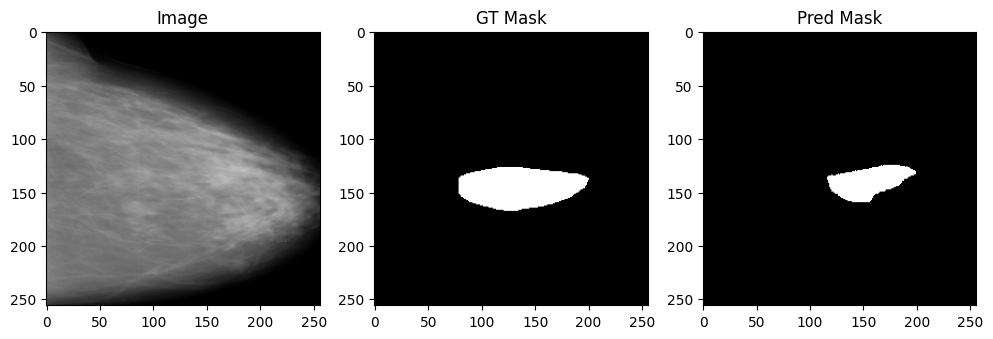

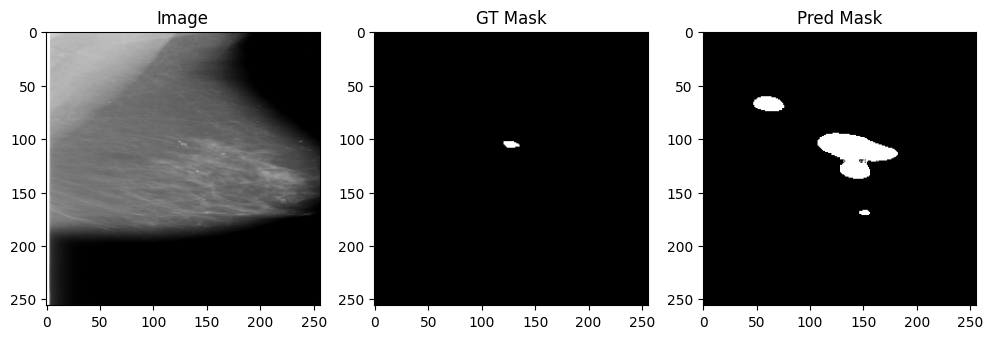

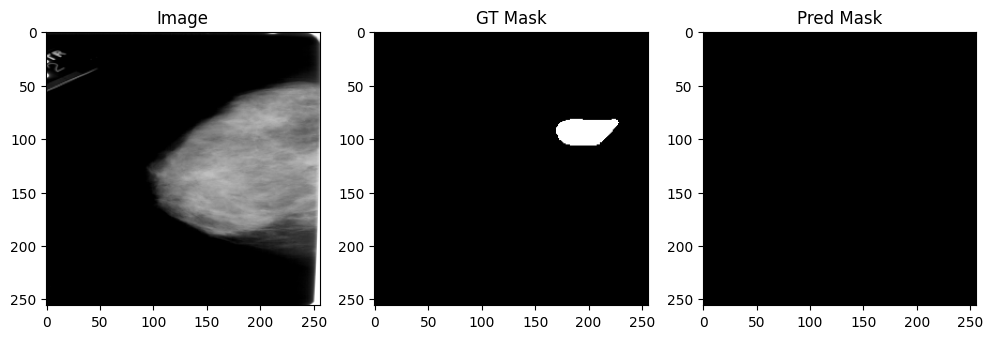

In [ ]:
imgs, masks = val_seq[0]
preds = model.predict(imgs)

for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(imgs[i].squeeze(), cmap="gray"); plt.title("Image")
    plt.subplot(1,3,2); plt.imshow(masks[i].squeeze(), cmap="gray"); plt.title("GT Mask")
    plt.subplot(1,3,3); plt.imshow((preds[i].squeeze()>0.5), cmap="gray"); plt.title("Pred Mask")
    plt.show()


In [ ]:
imgs, masks = val_seq[0]
preds = model.predict(imgs)

for i in range(3):
    p = preds[i].squeeze()
    print(f"Sample {i}: pred min={p.min():.4f}, max={p.max():.4f}, mean={p.mean():.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Sample 0: pred min=0.0001, max=0.9384, mean=0.0323
Sample 1: pred min=0.0000, max=0.9959, mean=0.0342
Sample 2: pred min=0.0000, max=0.4257, mean=0.0052


In [ ]:
imgs, masks = val_seq[0]
print("mask min/max:", masks.min(), masks.max())


mask min/max: 0.0 1.0


In [ ]:
from tensorflow.keras import layers, models

def double_conv(x, out_ch):
    x = layers.Conv2D(out_ch, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(out_ch, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def attention_block(x, g, inter_channels):
    """
    x: encoder 端的 skip feature
    g: decoder 端的 gating feature（上採樣後）
    inter_channels: 中間壓縮後的 channel 數
    """
    theta_x = layers.Conv2D(inter_channels, 1, padding="same")(x)
    phi_g   = layers.Conv2D(inter_channels, 1, padding="same")(g)

    add = layers.Add()([theta_x, phi_g])
    act = layers.ReLU()(add)

    psi = layers.Conv2D(1, 1, padding="same")(act)
    psi = layers.Activation("sigmoid")(psi)

    # broadcast 乘回原本的 x
    att = layers.Multiply()([x, psi])
    return att


def down_block(x, filters):
    c = double_conv(x, filters)
    p = layers.MaxPool2D((2, 2))(c)
    return c, p


def up_block(x, skip, filters):
    """
    x: 來自上一層 decoder 的 feature
    skip: encoder 對應層的 feature（會被 attention 過）
    """
    us = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)

    # attention gate：讓 skip 更專注在病灶附近
    att_skip = attention_block(skip, us, inter_channels=filters // 2)

    concat = layers.Concatenate()([us, att_skip])
    c = double_conv(concat, filters)
    return c


def build_att_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1, p1 = down_block(inputs, 64)
    c2, p2 = down_block(p1, 128)
    c3, p3 = down_block(p2, 256)
    c4, p4 = down_block(p3, 512)

    # Bottleneck
    bn = double_conv(p4, 1024)

    # Decoder + Attention 跳接
    u4 = up_block(bn, c4, 512)
    u3 = up_block(u4, c3, 256)
    u2 = up_block(u3, c2, 128)
    u1 = up_block(u2, c1, 64)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(u1)

    model = models.Model(inputs, outputs, name="att_unet_mammo")
    return model

model = build_att_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[dice_coef],
)

model.summary()


Model: "att_unet_mammo"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ re_lu_20[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ re_lu_21[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,404,901 (119.80 MB)

 Trainable params: 31,393,125 (119.76 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - dice_coef: 0.0542 - loss: 0.6159
Epoch 1: val_dice_coef improved from -inf to 0.03364, saving model to /content/drive/MyDrive/unet/result_att/att_unet_best.weights.h5
317/317 ━━━━━━━━━━━━━━━━━━━━ 150s 368ms/step - dice_coef: 0.0542 - loss: 0.6158 - val_dice_coef: 0.0336 - val_loss: 0.5749
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - dice_coef: 0.0734 - loss: 0.5540
Epoch 2: val_dice_coef improved from 0.03364 to 0.08264, saving model to /content/drive/MyDrive/unet/result_att/att_unet_best.weights.h5
317/317 ━━━━━━━━━━━━━━━━━━━━ 108s 340ms/step - dice_coef: 0.0734 - loss: 0.5540 - val_dice_coef: 0.0826 - val_loss: 0.5481
Epoch 3/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - dice_coef: 0.1001 - loss: 0.5377
Epoch 3: val_dice_coef did not improve from 0.08264
317/317 ━━━━━━━━━━━━━━━━━━━━ 106s 334ms/step - dice_coef: 0.1001 - loss: 0.5378 - val_dice_coef: 0.0787 - val_loss: 0.5360
Epoch 4/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0

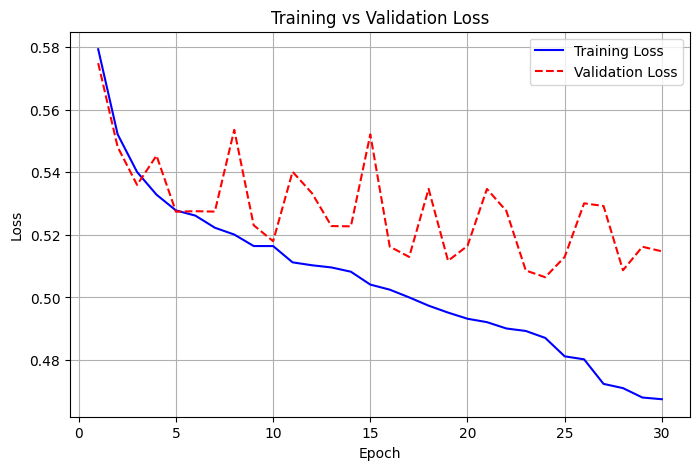

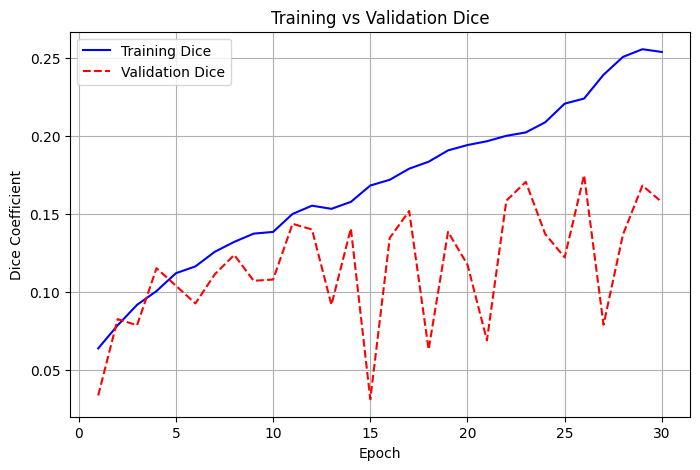

In [ ]:
import os
import tensorflow as tf

# ======================================
# 1. 設定結果儲存資料夾
# ======================================
SAVE_DIR = "/content/drive/MyDrive/unet/result_att"
os.makedirs(SAVE_DIR, exist_ok=True)

best_weights_path = os.path.join(SAVE_DIR, "att_unet_best.weights.h5")


# ======================================
# 2. ModelCheckpoint：存 val_dice_coef 最佳權重
# ======================================
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    best_weights_path,
    monitor="val_dice_coef",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)


# ======================================
# 3. EarlyStopping：也是看 val_dice_coef
# ======================================
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

# ======================================
# 4. 開始訓練
# ======================================
EPOCHS = 30

history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb],
)

print("Best weights saved at:", best_weights_path)

import matplotlib.pyplot as plt

# 取得 loss 資料
train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r--", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

train_dice = history.history["dice_coef"]
val_dice   = history.history["val_dice_coef"]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_dice, "b-", label="Training Dice")
plt.plot(epochs, val_dice, "r--", label="Validation Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Training vs Validation Dice")
plt.legend()
plt.grid(True)
plt.show()



### test your model and save predicted results

Model created.
Model compiled.
Load weights from: /content/drive/MyDrive/unet/result_att/att_unet_best.weights.h5
Weights loaded.
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - dice_coef: 0.1845 - loss: 0.9191

Val/Test Loss : 0.9281
Val/Test Dice : 0.1751


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sample 0: pred min=0.0001, max=0.9451, mean=0.0315
Sample 1: pred min=0.0000, max=0.9976, mean=0.0439
Sample 2: pred min=0.0000, max=0.9399, mean=0.0180


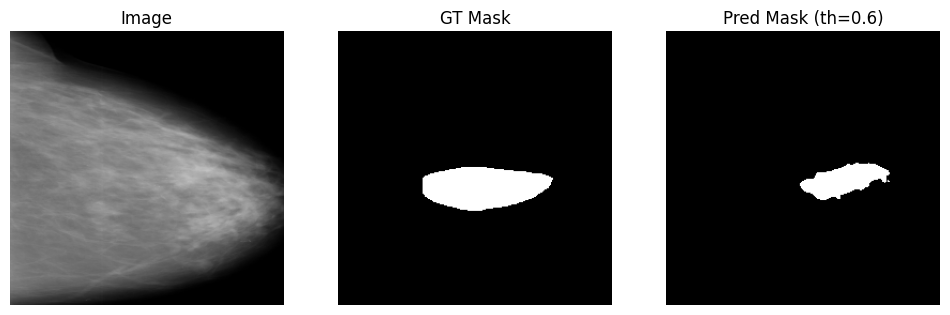

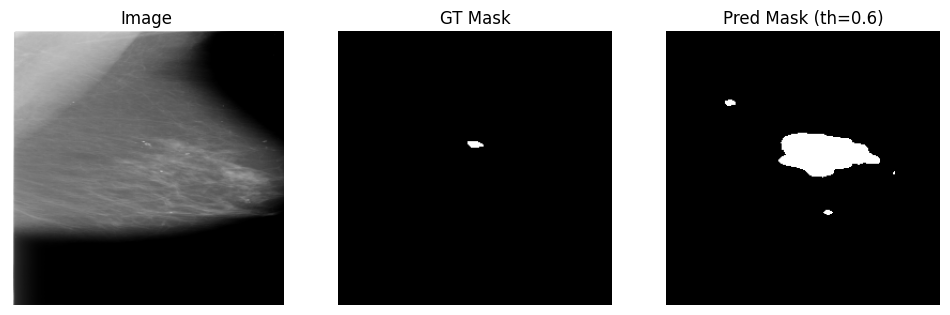

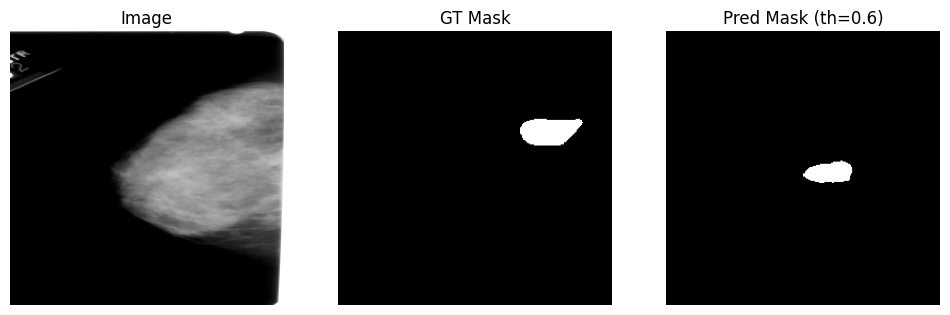

Done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.backend.clear_session()

# 1. 跟訓練時一樣的 Attention U-Net
model = build_att_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3))
print("Model created.")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,     # ⭐ 一定要跟訓練時同一個 combined_loss
    metrics=[dice_coef]
)
print("Model compiled.")

# 2. 載入「這一次 Attention U-Net 訓練出來」的權重
best_weights_path = "/content/drive/MyDrive/unet/result_att/att_unet_best.weights.h5"
print("Load weights from:", best_weights_path)
model.load_weights(best_weights_path)
print("Weights loaded.")

# 3. 在 val_seq 上整體評估
test_loss, test_dice = model.evaluate(val_seq, verbose=1)
print(f"\nVal/Test Loss : {test_loss:.4f}")
print(f"Val/Test Dice : {test_dice:.4f}")

# 4. 抓一個 batch 做可視化
imgs, masks = val_seq[0]
preds = model.predict(imgs)

for i in range(min(3, imgs.shape[0])):
    p = preds[i].squeeze()
    print(f"Sample {i}: pred min={p.min():.4f}, max={p.max():.4f}, mean={p.mean():.4f}")

th = 0.6  # 門檻可以再微調

for i in range(min(3, imgs.shape[0])):
    img  = imgs[i].squeeze()
    gt   = masks[i].squeeze()
    pred = (preds[i].squeeze() > th).astype(np.float32)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title("Image"); plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt, cmap="gray")
    plt.title("GT Mask"); plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap="gray")
    plt.title(f"Pred Mask (th={th})"); plt.axis("off")

    plt.show()

print("Done.")
